In [2]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

import gym
from gym.spaces import Discrete
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.mc_off_policy_agent import OffPolicyMonteCarloAgent
from source.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


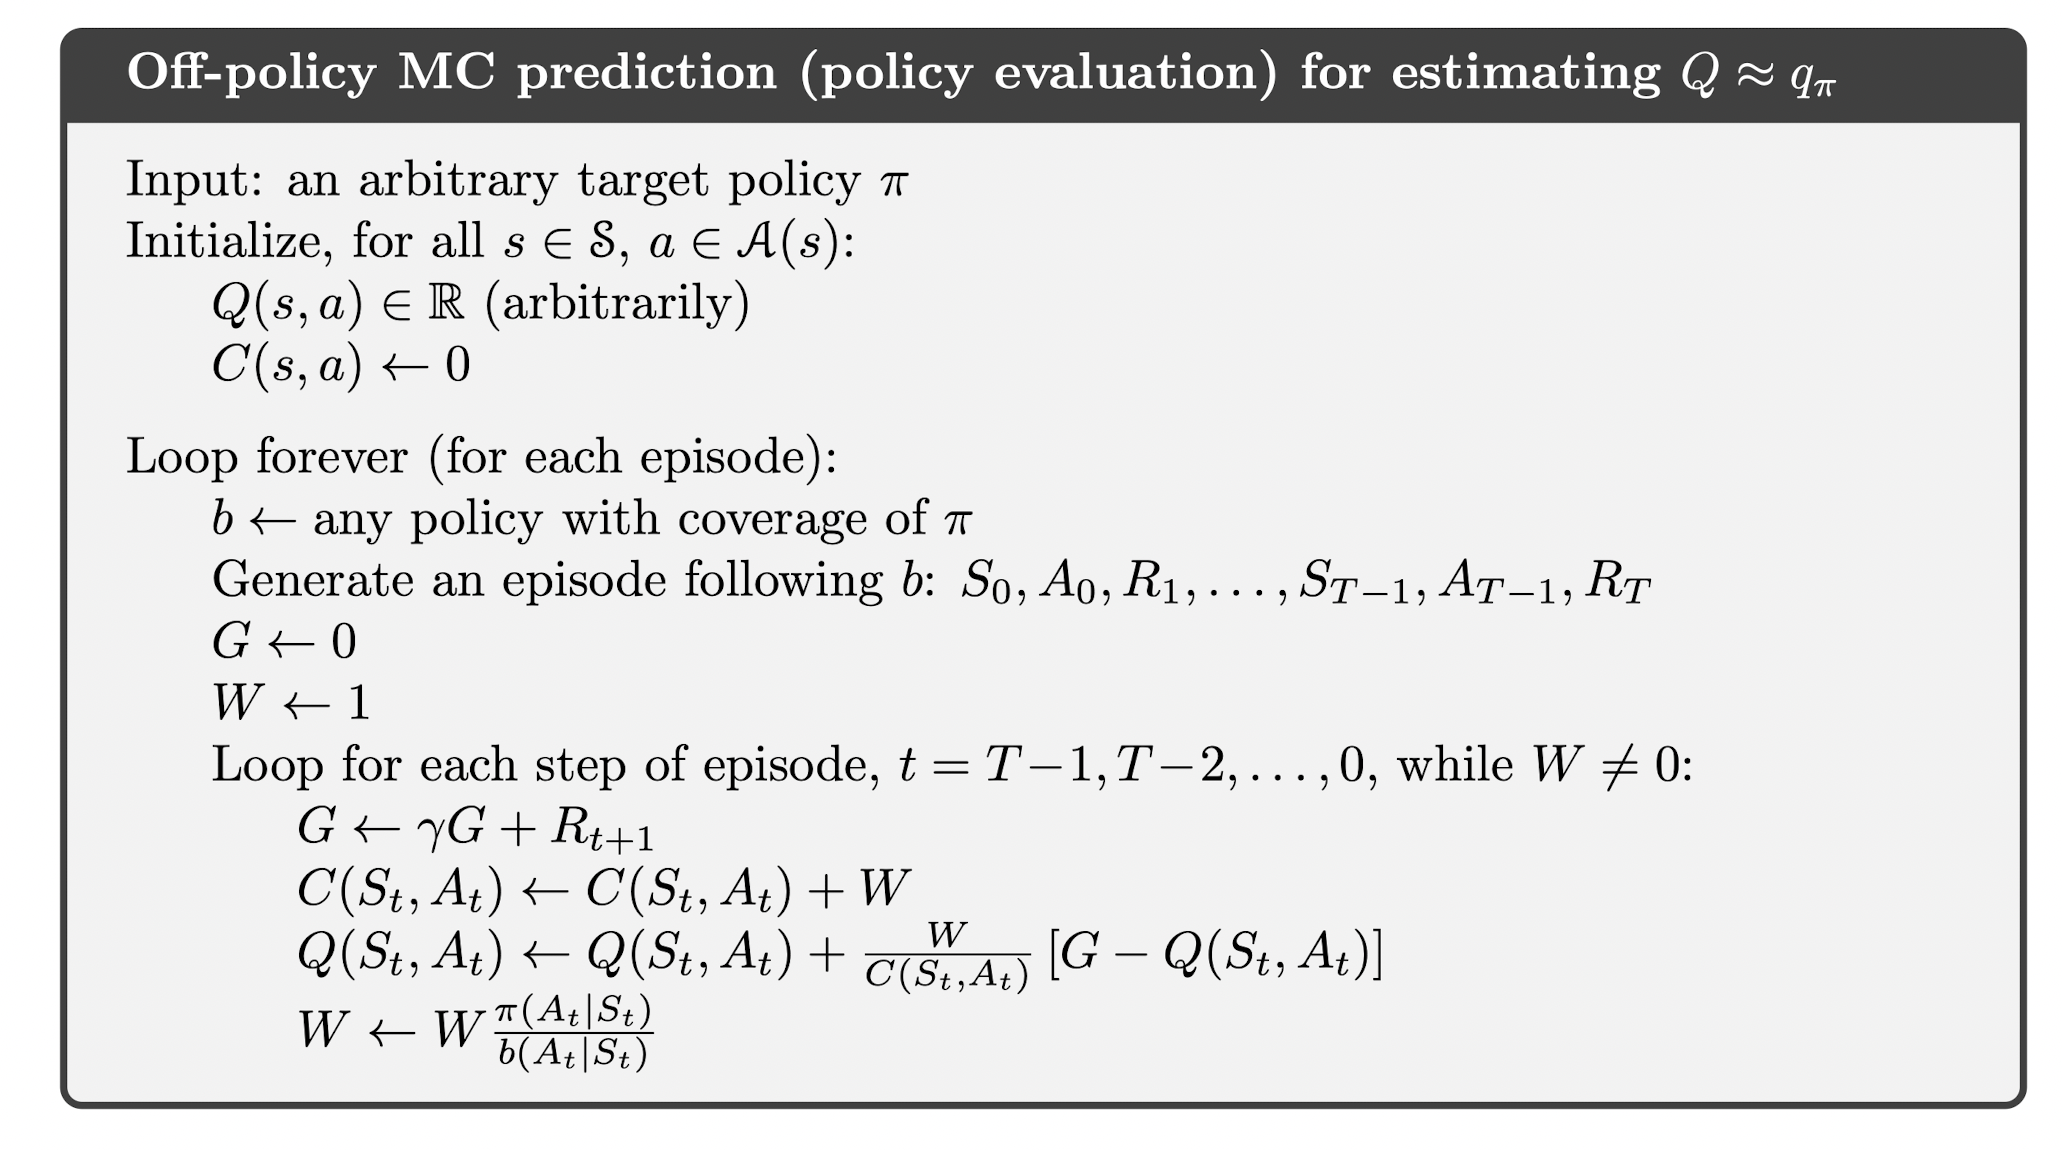

In [5]:
def play_episode(policy: np.array, env: gym.Env):
  prev_state, _ = env.reset()
  terminal = False
  episode = []
  while not terminal:
    action = np.random.choice(len(policy[prev_state]), p = policy[prev_state])
    state, reward, terminal, truncated, info = env.step(action)
    episode.append((prev_state, action, reward))
    prev_state = state
  return episode

In [7]:
### Off policy learning ###
# Create Environment.
#env = gym.make('Taxi-v3')
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
video_path = os.path.join(ROOT, "video/mc_off_policy.mp4")
agent = OffPolicyMonteCarloAgent(
  state_space=env.observation_space, 
  action_space=env.action_space, 
  discount_rate=0.9
)
rand_policy = np.random.rand(env.observation_space.n, env.action_space.n)
behavior_policy = rand_policy / rand_policy.sum(axis=1, keepdims=True)
max_episode = 1000
rewarding = 0
for i in tqdm(range(max_episode)):
  episode = play_episode(behavior_policy, env)
  if (episode[-1][2] > 0):
    rewarding += 1
  agent.control(behavior_policy, episode)
  #behavior_policy = get_epsilon_greedy_policy_from_action_values(agent._Q, epsilon=0.2)
print(f"\nrewarding episodes: {rewarding}")

# Play with learned target policy
play_episode(agent._policy, env)


100%|██████████| 1000/1000 [00:00<00:00, 7935.94it/s]


rewarding episodes: 13


[(0, 2, 0.0),
 (1, 2, 0.0),
 (2, 1, 0.0),
 (6, 1, 0.0),
 (10, 1, 0.0),
 (14, 2, 1.0)]

[[b'RIGH' b'RIGH' b'DOWN' b'LEFT']
 [b'DOWN' b'LEFT' b'DOWN' b'LEFT']
 [b'RIGH' b'DOWN' b'DOWN' b'LEFT']
 [b'LEFT' b'RIGH' b'RIGH' b'LEFT']]
[[0.25      0.25      0.25      0.25     ]
 [0.4782969 0.25      0.        0.25     ]
 [0.25      0.6561    0.25      0.25     ]
 [0.25      0.        0.25      0.25     ]]
[[0.25   0.     0.729  0.    ]
 [0.6561 0.25   0.81   0.25  ]
 [0.     0.81   0.9    0.25  ]
 [0.25   0.81   0.9    0.25  ]]
[[0.59049 0.6561  0.25    0.25   ]
 [0.      0.25    0.      0.25   ]
 [0.729   0.81    0.      0.25   ]
 [0.25    0.9     1.      0.25   ]]
[[0.25     0.25     0.25     0.25    ]
 [0.531441 0.25     0.25     0.25    ]
 [0.59049  0.       0.729    0.25    ]
 [0.25     0.729    0.25     0.25    ]]


Text(0.5, 1.0, 'state_values')

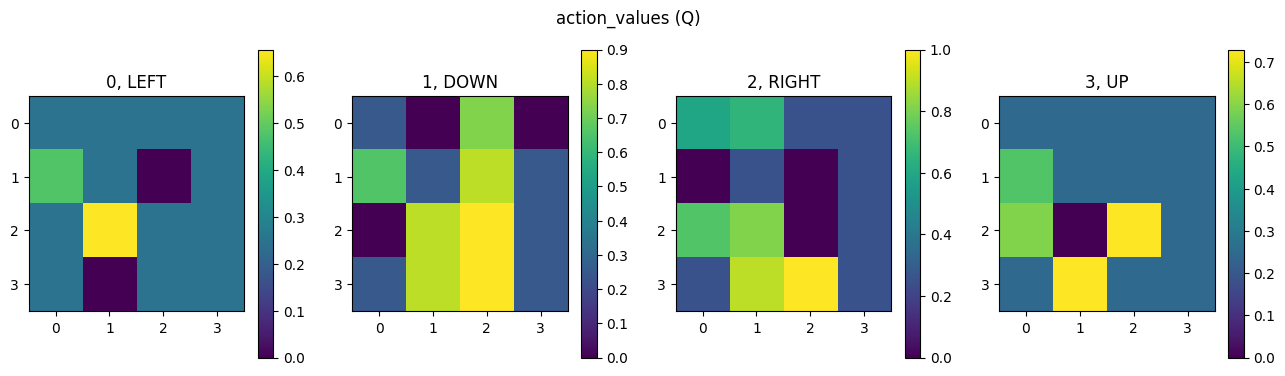

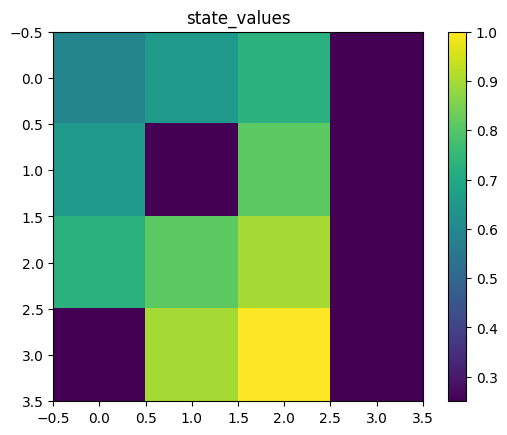

In [8]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
shape = (4,4,4)
## large
#shape = (8,8,4)
direction = {
  0:"LEFT",
  1:"DOWN",
  2:"RIGHT",
  3:"UP"
}
actions = np.argmax(agent._policy, axis=1)
actions = actions.reshape(shape[:2])
named_actions = np.chararray(actions.shape, itemsize=4)
map = [[""] * shape[1]] * shape[0]
for idx, val in np.ndenumerate(actions):
  named_actions[idx] = direction[val]
  #map[idx[0]][idx[1]] = direction[val]
print(named_actions)

action_values = agent._Q.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(2, figsize=(16,4))
plt.suptitle("action_values (Q)")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(f"{i}, {direction[i]}")
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')
  print(action_values[:,:,i])


plt.figure(3)
state_values = get_state_values_from_action_values(agent._Q, agent._policy)
plt.imshow(state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


# Summary

## Monte Carlo Off policy learning 
Off policy learning means observing a given behavior policy while learing a different target policy.

The learning speed depends on the behavior policy, for a random policy the learning speed is quite slow on average. 
### Prediction
Prediction is only used to evaluate a policy, ie: given a target policy, evaluate Q(s,a) and V(s)

### Control
Control is evaluating Q(s,a) and using it to update the policy using GPI. One step for policy evaluation (update Q(s,a) using observed sequence with importance sampling), and one step for policy iteration (greedy given Q(s,a)

